# Fraud Detection Data Preprocessing Pipeline
## Tugas Besar 2 IF3070 – Dasar Inteligensi Artifisial

**Author:** AbyuDAIya-Ganbatte Team

This notebook implements a comprehensive preprocessing pipeline for fraud detection data, including:
- Missing value imputation
- One-hot encoding
- Feature scaling
- Outlier handling
- Advanced feature engineering

## 1. Import Libraries

In [13]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
np.random.seed(42)

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load Data

In [14]:
# Load training and test data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print(f"Training data shape: {train.shape}")
print(f"Test data shape: {test.shape}")
print(f"\nTraining data columns: {train.columns.tolist()}")

Training data shape: (100000, 31)
Test data shape: (100000, 30)

Training data columns: ['ID', 'transaction_id', 'user_id', 'age', 'gender', 'country', 'device_type', 'device_os', 'merchant_category', 'transaction_amount', 'transaction_type', 'time_of_day', 'day_of_week', 'transaction_duration', 'num_prev_transactions', 'avg_transaction_amount', 'std_transaction_amount', 'transactions_last_24h', 'transactions_last_1h', 'failed_login_attempts', 'ip_risk_score', 'device_trust_score', 'account_age_days', 'has_chargeback_history', 'shared_ip_users', 'shared_device_users', 'merchant_risk', 'country_risk', 'distance_from_home', 'is_new_country', 'is_fraud']


## 3. Exploratory Data Analysis

In [15]:
# Display first few rows
print("First 5 rows of training data:")
display(train.head())

print("\nFirst 5 rows of test data:")
display(test.head())

First 5 rows of training data:


,ID,transaction_id,user_id,age,gender,country,device_type,device_os,merchant_category,transaction_amount,transaction_type,time_of_day,day_of_week,transaction_duration,num_prev_transactions,avg_transaction_amount,std_transaction_amount,transactions_last_24h,transactions_last_1h,failed_login_attempts,ip_risk_score,device_trust_score,account_age_days,has_chargeback_history,shared_ip_users,shared_device_users,merchant_risk,country_risk,distance_from_home,is_new_country,is_fraud
0,0,T0065716,15307,35,M,UK,mobile,Android,clothing,17.70,purchase,18,1,3.04,34,91.01,56.68,0,0,1,0.464,0.793,1056,0,1,1,0.10,0.04,9.66,0,1
1,1,T0027857,1226,54,F,IN,mobile,Android,restaurants,NaN,purchase,7,3,0.33,28,NaN,50.11,1,0,0,0.997,NaN,1867,0,1,1,0.12,0.10,12.05,0,1
2,2,T0055953,16072,35,M,US,desktop,iOS,restaurants,5.20,purchase,15,5,7.85,31,111.05,20.79,3,0,0,0.940,0.281,1726,1,2,2,0.12,0.05,181.28,0,0
3,3,T0083660,725,23,F,US,mobile,Android,electronics,180.70,purchase,18,3,4.71,32,27.88,73.32,3,0,0,0.166,0.061,30,1,1,1,0.30,0.05,33.26,0,0
4,4,T0017674,7367,32,M,UK,mobile,Android,gas,35.45,purchase,8,3,1.56,21,81.34,73.28,0,0,0,0.870,0.592,1386,0,3,1,0.05,0.04,174.83,0,0



First 5 rows of test data:


,ID,transaction_id,user_id,age,gender,country,device_type,device_os,merchant_category,transaction_amount,transaction_type,time_of_day,day_of_week,transaction_duration,num_prev_transactions,avg_transaction_amount,std_transaction_amount,transactions_last_24h,transactions_last_1h,failed_login_attempts,ip_risk_score,device_trust_score,account_age_days,has_chargeback_history,shared_ip_users,shared_device_users,merchant_risk,country_risk,distance_from_home,is_new_country
0,0,T0065716,1199,58,M,UK,tablet,Android,gas,3.54,topup,6,0,4.03,42,102.55,55.15,2,0,0,0.906,0.595,2305,0,3,3,0.05,0.04,13.55,0
1,1,T0027857,29841,71,M,BR,desktop,Android,groceries,94.80,transfer,17,0,15.68,20,40.50,70.61,2,0,0,0.917,0.553,2911,0,3,3,0.05,0.13,6.09,0
2,2,T0055953,25403,76,F,CA,tablet,iOS,restaurants,84.45,transfer,18,0,0.13,32,80.61,77.97,2,1,0,0.675,0.614,2952,0,1,1,0.12,0.03,118.59,0
3,3,T0083660,27600,70,F,UK,mobile,iOS,gas,23.66,topup,20,4,3.75,34,7.48,19.61,4,0,0,0.541,0.493,2539,0,2,2,0.05,0.04,255.86,0
4,4,T0017674,21543,70,F,US,mobile,Windows,travel,81.45,transfer,18,2,6.55,32,88.94,54.31,1,1,0,0.832,0.183,1017,0,1,2,0.35,0.05,16.19,0


In [16]:
# Check data types and missing values
print("Training data info:")
print(train.info())

print("\n" + "="*50)
print("Missing values in training data:")
missing_train = train.isnull().sum()
print(missing_train[missing_train > 0])

print("\n" + "="*50)
print("Missing values in test data:")
missing_test = test.isnull().sum()
print(missing_test[missing_test > 0])

Training data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 31 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   ID                      100000 non-null  int64  
 1   transaction_id          100000 non-null  object 
 2   user_id                 100000 non-null  int64  
 3   age                     100000 non-null  int64  
 4   gender                  100000 non-null  object 
 5   country                 100000 non-null  object 
 6   device_type             100000 non-null  object 
 7   device_os               100000 non-null  object 
 8   merchant_category       100000 non-null  object 
 9   transaction_amount      97581 non-null   float64
 10  transaction_type        100000 non-null  object 
 11  time_of_day             100000 non-null  int64  
 12  day_of_week             100000 non-null  int64  
 13  transaction_duration    100000 non-null  float64
 14  n

Target distribution:
is_fraud
0    85872
1    14128
Name: count, dtype: int64

Fraud percentage: 14.13%


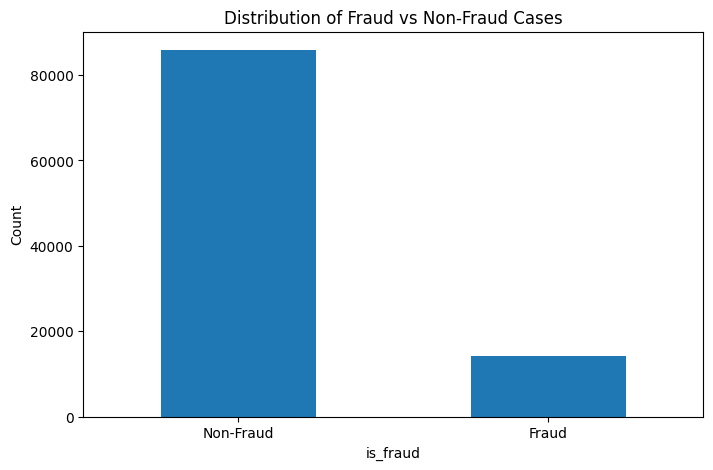

In [17]:
# Check target distribution
print("Target distribution:")
print(train['is_fraud'].value_counts())
print(f"\nFraud percentage: {train['is_fraud'].mean() * 100:.2f}%")

# Visualize target distribution
plt.figure(figsize=(8, 5))
train['is_fraud'].value_counts().plot(kind='bar')
plt.title('Distribution of Fraud vs Non-Fraud Cases')
plt.xlabel('is_fraud')
plt.ylabel('Count')
plt.xticks([0, 1], ['Non-Fraud', 'Fraud'], rotation=0)
plt.show()

## 4. Data Preprocessing Setup

In [18]:
# Store IDs for later use
test_ids = test['ID'].values
train_ids = train['ID'].values

print(f"Stored {len(train_ids)} training IDs")
print(f"Stored {len(test_ids)} test IDs")

Stored 100000 training IDs
Stored 100000 test IDs


In [19]:
# Separate target variable
y_train = train['is_fraud'].values

print(f"Target variable shape: {y_train.shape}")
print(f"Target variable type: {y_train.dtype}")

Target variable shape: (100000,)
Target variable type: int64


In [20]:
# Drop unnecessary columns
cols_to_drop = ['ID', 'transaction_id', 'user_id']

train_features = train.drop(columns=['is_fraud'] + cols_to_drop, errors='ignore')
test_features = test.drop(columns=cols_to_drop, errors='ignore')

print(f"Training features shape: {train_features.shape}")
print(f"Test features shape: {test_features.shape}")

Training features shape: (100000, 27)
Test features shape: (100000, 27)


In [21]:
# Identify column types
numerical_cols = train_features.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = train_features.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Numerical columns ({len(numerical_cols)}):")
print(numerical_cols)
print(f"\nCategorical columns ({len(categorical_cols)}):")
print(categorical_cols)

Numerical columns (21):
['age', 'transaction_amount', 'time_of_day', 'day_of_week', 'transaction_duration', 'num_prev_transactions', 'avg_transaction_amount', 'std_transaction_amount', 'transactions_last_24h', 'transactions_last_1h', 'failed_login_attempts', 'ip_risk_score', 'device_trust_score', 'account_age_days', 'has_chargeback_history', 'shared_ip_users', 'shared_device_users', 'merchant_risk', 'country_risk', 'distance_from_home', 'is_new_country']

Categorical columns (6):
['gender', 'country', 'device_type', 'device_os', 'merchant_category', 'transaction_type']


## 5. Missing Value Imputation

In [22]:
# Handle missing values in training data
train_filled = train_features.copy()
imputation_values = {}

# Mean imputation for numerical columns
for col in numerical_cols:
    if col in train_filled.columns and train_filled[col].isnull().any():
        mean_value = train_filled[col].mean()
        train_filled[col] = train_filled[col].fillna(mean_value)
        imputation_values[col] = {'type': 'mean', 'value': mean_value}
        print(f"Imputed {col} with mean: {mean_value:.4f}")

# Mode imputation for categorical columns
for col in categorical_cols:
    if col in train_filled.columns and train_filled[col].isnull().any():
        mode_value = train_filled[col].mode()
        if len(mode_value) > 0:
            mode_value = mode_value[0]
            train_filled[col] = train_filled[col].fillna(mode_value)
            imputation_values[col] = {'type': 'mode', 'value': mode_value}
            print(f"Imputed {col} with mode: {mode_value}")

print(f"\nImputation complete. Imputed {len(imputation_values)} columns.")

Imputed transaction_amount with mean: 126.8553
Imputed avg_transaction_amount with mean: 69.9697
Imputed device_trust_score with mean: 0.4995

Imputation complete. Imputed 3 columns.


In [23]:
# Handle missing values in training data
test_filled = test_features.copy()
imputation_values = {}

# Mean imputation for numerical columns
for col in numerical_cols:
    if col in test_filled.columns and test_filled[col].isnull().any():
        mean_value = test_filled[col].mean()
        test_filled[col] = test_filled[col].fillna(mean_value)
        imputation_values[col] = {'type': 'mean', 'value': mean_value}
        print(f"Imputed {col} with mean: {mean_value:.4f}")

# Mode imputation for categorical columns
for col in categorical_cols:
    if col in test_filled.columns and test_filled[col].isnull().any():
        mode_value = test_filled[col].mode()
        if len(mode_value) > 0:
            mode_value = mode_value[0]
            test_filled[col] = test_filled[col].fillna(mode_value)
            imputation_values[col] = {'type': 'mode', 'value': mode_value}
            print(f"Imputed {col} with mode: {mode_value}")

print(f"\nImputation complete. Imputed {len(imputation_values)} columns.")

Imputed transaction_amount with mean: 145.2201
Imputed avg_transaction_amount with mean: 70.1094
Imputed device_trust_score with mean: 0.4995

Imputation complete. Imputed 3 columns.


## 6. Feature Engineering

### 6.1 Ratio Features

In [24]:
# Create ratio features
ratio_pairs = [
    ('transaction_amount', 'avg_transaction_amount', 'amount_vs_avg_ratio'),
    ('transaction_amount', 'std_transaction_amount', 'amount_vs_std_ratio'),
    ('transactions_last_1h', 'transactions_last_24h', 'hourly_vs_daily_ratio'),
    ('failed_login_attempts', 'num_prev_transactions', 'failed_vs_total_ratio'),
    ('shared_ip_users', 'shared_device_users', 'ip_vs_device_shared_ratio'),
]

for num, denom, name in ratio_pairs:
    if num in train_filled.columns and denom in train_filled.columns:
        # Train
        denom_safe = train_filled[denom].replace(0, 1e-10)
        train_filled[name] = train_filled[num] / denom_safe
        
        # Test
        denom_safe = test_filled[denom].replace(0, 1e-10)
        test_filled[name] = test_filled[num] / denom_safe
        
        print(f"Created ratio feature: {name}")

print(f"\nTotal features after ratio creation: {train_filled.shape[1]}")

Created ratio feature: amount_vs_avg_ratio
Created ratio feature: amount_vs_std_ratio
Created ratio feature: hourly_vs_daily_ratio
Created ratio feature: failed_vs_total_ratio
Created ratio feature: ip_vs_device_shared_ratio

Total features after ratio creation: 32


### 6.2 Log-Transformed Features

In [25]:
# Create log-transformed features for skewed distributions
log_candidates = [
    'transaction_amount', 'avg_transaction_amount', 'std_transaction_amount',
    'account_age_days', 'distance_from_home', 'num_prev_transactions'
]

for col in log_candidates:
    if col in train_filled.columns:
        # Only log transform non-negative columns
        min_val = train_filled[col].min()
        if min_val >= 0:
            train_filled[f'{col}_log'] = np.log1p(train_filled[col])
            test_filled[f'{col}_log'] = np.log1p(test_filled[col])
            print(f"Created log feature: {col}_log")

print(f"\nTotal features after log transformation: {train_filled.shape[1]}")

Created log feature: transaction_amount_log
Created log feature: std_transaction_amount_log
Created log feature: account_age_days_log
Created log feature: distance_from_home_log
Created log feature: num_prev_transactions_log

Total features after log transformation: 37


### 6.3 Interaction Features

In [26]:
# Risk Score Interactions
if 'ip_risk_score' in train_filled.columns and 'device_trust_score' in train_filled.columns:
    train_filled['risk_interaction'] = train_filled['ip_risk_score'] * (1 - train_filled['device_trust_score'] / 100)
    test_filled['risk_interaction'] = test_filled['ip_risk_score'] * (1 - test_filled['device_trust_score'] / 100)
    print("Created: risk_interaction")

if 'merchant_risk' in train_filled.columns and 'country_risk' in train_filled.columns:
    train_filled['merchant_country_risk'] = train_filled['merchant_risk'] * train_filled['country_risk']
    test_filled['merchant_country_risk'] = test_filled['merchant_risk'] * test_filled['country_risk']
    print("Created: merchant_country_risk")

# Transaction amount anomaly indicators
if 'transaction_amount' in train_filled.columns and 'avg_transaction_amount' in train_filled.columns:
    std_col = 'std_transaction_amount'
    if std_col in train_filled.columns and train_filled[std_col].mean() > 0:
        train_filled['amount_zscore'] = (train_filled['transaction_amount'] - train_filled['avg_transaction_amount']) / (train_filled[std_col] + 1e-6)
        test_filled['amount_zscore'] = (test_filled['transaction_amount'] - test_filled['avg_transaction_amount']) / (test_filled[std_col] + 1e-6)
        print("Created: amount_zscore")

# Velocity-based features
if 'transactions_last_24h' in train_filled.columns and 'transactions_last_1h' in train_filled.columns:
    train_filled['hourly_concentration'] = train_filled['transactions_last_1h'] / (train_filled['transactions_last_24h'] + 1)
    test_filled['hourly_concentration'] = test_filled['transactions_last_1h'] / (test_filled['transactions_last_24h'] + 1)
    print("Created: hourly_concentration")

# Account trust features
if 'account_age_days' in train_filled.columns and 'num_prev_transactions' in train_filled.columns:
    train_filled['tx_per_day_age'] = train_filled['num_prev_transactions'] / (train_filled['account_age_days'] + 1)
    test_filled['tx_per_day_age'] = test_filled['num_prev_transactions'] / (test_filled['account_age_days'] + 1)
    print("Created: tx_per_day_age")

# New user risk
if 'is_new_country' in train_filled.columns and 'distance_from_home' in train_filled.columns:
    train_filled['new_location_distance'] = train_filled['is_new_country'] * train_filled['distance_from_home']
    test_filled['new_location_distance'] = test_filled['is_new_country'] * test_filled['distance_from_home']
    print("Created: new_location_distance")

# Failed login impact
if 'failed_login_attempts' in train_filled.columns and 'transaction_amount' in train_filled.columns:
    train_filled['failed_login_amount'] = train_filled['failed_login_attempts'] * train_filled['transaction_amount']
    test_filled['failed_login_amount'] = test_filled['failed_login_attempts'] * test_filled['transaction_amount']
    print("Created: failed_login_amount")

# Shared resource risk
if 'shared_ip_users' in train_filled.columns and 'shared_device_users' in train_filled.columns:
    train_filled['total_shared_users'] = train_filled['shared_ip_users'] + train_filled['shared_device_users']
    test_filled['total_shared_users'] = test_filled['shared_ip_users'] + test_filled['shared_device_users']
    
    train_filled['shared_resource_product'] = train_filled['shared_ip_users'] * train_filled['shared_device_users']
    test_filled['shared_resource_product'] = test_filled['shared_ip_users'] * test_filled['shared_device_users']
    print("Created: total_shared_users, shared_resource_product")

# Time-based risk
if 'time_of_day' in train_filled.columns:
    train_filled['is_night_time'] = ((train_filled['time_of_day'] >= 0) & (train_filled['time_of_day'] <= 6) | 
                                      (train_filled['time_of_day'] >= 22)).astype(float)
    test_filled['is_night_time'] = ((test_filled['time_of_day'] >= 0) & (test_filled['time_of_day'] <= 6) | 
                                     (test_filled['time_of_day'] >= 22)).astype(float)
    print("Created: is_night_time")

if 'day_of_week' in train_filled.columns:
    train_filled['is_weekend'] = (train_filled['day_of_week'] >= 5).astype(float)
    test_filled['is_weekend'] = (test_filled['day_of_week'] >= 5).astype(float)
    print("Created: is_weekend")

# Chargeback history interaction
if 'has_chargeback_history' in train_filled.columns and 'transaction_amount' in train_filled.columns:
    train_filled['chargeback_high_amount'] = train_filled['has_chargeback_history'] * (train_filled['transaction_amount'] > train_filled['transaction_amount'].median()).astype(float)
    test_filled['chargeback_high_amount'] = test_filled['has_chargeback_history'] * (test_filled['transaction_amount'] > train_filled['transaction_amount'].median()).astype(float)
    print("Created: chargeback_high_amount")

# Additional high-value interactions
if 'ip_risk_score' in train_filled.columns and 'transaction_amount' in train_filled.columns:
    train_filled['high_risk_high_amount'] = train_filled['ip_risk_score'] * train_filled['transaction_amount']
    test_filled['high_risk_high_amount'] = test_filled['ip_risk_score'] * test_filled['transaction_amount']
    print("Created: high_risk_high_amount")

if 'failed_login_attempts' in train_filled.columns and 'ip_risk_score' in train_filled.columns:
    train_filled['failed_login_risk'] = train_filled['failed_login_attempts'] * train_filled['ip_risk_score']
    test_filled['failed_login_risk'] = test_filled['failed_login_attempts'] * test_filled['ip_risk_score']
    print("Created: failed_login_risk")

if 'is_new_country' in train_filled.columns and 'transaction_amount' in train_filled.columns:
    train_filled['new_country_amount'] = train_filled['is_new_country'] * train_filled['transaction_amount']
    test_filled['new_country_amount'] = test_filled['is_new_country'] * test_filled['transaction_amount']
    print("Created: new_country_amount")

# Squared features for important risk indicators
if 'ip_risk_score' in train_filled.columns:
    train_filled['ip_risk_squared'] = train_filled['ip_risk_score'] ** 2
    test_filled['ip_risk_squared'] = test_filled['ip_risk_score'] ** 2
    print("Created: ip_risk_squared")

if 'merchant_risk' in train_filled.columns:
    train_filled['merchant_risk_squared'] = train_filled['merchant_risk'] ** 2
    test_filled['merchant_risk_squared'] = test_filled['merchant_risk'] ** 2
    print("Created: merchant_risk_squared")

if 'country_risk' in train_filled.columns:
    train_filled['country_risk_squared'] = train_filled['country_risk'] ** 2
    test_filled['country_risk_squared'] = test_filled['country_risk'] ** 2
    print("Created: country_risk_squared")

# Combined risk score
risk_cols = []
if 'ip_risk_score' in train_filled.columns:
    risk_cols.append('ip_risk_score')
if 'merchant_risk' in train_filled.columns:
    risk_cols.append('merchant_risk')
if 'country_risk' in train_filled.columns:
    risk_cols.append('country_risk')
if len(risk_cols) > 0:
    train_filled['combined_risk'] = train_filled[risk_cols].mean(axis=1)
    test_filled['combined_risk'] = test_filled[risk_cols].mean(axis=1)
    print("Created: combined_risk")

print(f"\nTotal features after interaction creation: {train_filled.shape[1]}")

Created: risk_interaction
Created: merchant_country_risk
Created: amount_zscore
Created: hourly_concentration
Created: tx_per_day_age
Created: new_location_distance
Created: failed_login_amount
Created: total_shared_users, shared_resource_product
Created: is_night_time
Created: is_weekend
Created: chargeback_high_amount
Created: high_risk_high_amount
Created: failed_login_risk
Created: new_country_amount
Created: ip_risk_squared
Created: merchant_risk_squared
Created: country_risk_squared
Created: combined_risk

Total features after interaction creation: 56


In [27]:
# Update numerical columns list after feature engineering
numerical_cols = train_filled.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = train_filled.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Features after engineering:")
print(f"  - Numerical: {len(numerical_cols)}")
print(f"  - Categorical: {len(categorical_cols)}")

Features after engineering:
  - Numerical: 50
  - Categorical: 6


## 7. One-Hot Encoding

In [28]:
# Perform one-hot encoding on training data
train_encoded = train_filled.copy()
encoding_info = {}

for col in categorical_cols:
    if col in train_encoded.columns:
        # Get unique categories
        categories = train_encoded[col].unique()
        categories = [c for c in categories if pd.notna(c)]
        categories = sorted(categories)
        
        encoding_info[col] = categories
        
        # Create dummy columns
        for category in categories:
            new_col_name = f"{col}_{category}"
            train_encoded[new_col_name] = (train_encoded[col] == category).astype(int)
        
        # Drop original column
        train_encoded = train_encoded.drop(columns=[col])
        print(f"Encoded {col}: {len(categories)} categories")

print(f"\nShape after encoding: {train_encoded.shape}")

Encoded gender: 2 categories
Encoded country: 10 categories
Encoded device_type: 3 categories
Encoded device_os: 5 categories
Encoded merchant_category: 9 categories
Encoded transaction_type: 4 categories

Shape after encoding: (100000, 83)


In [29]:
# Apply same encoding to test data
test_encoded = test_filled.copy()

for col, categories in encoding_info.items():
    if col in test_encoded.columns:
        for category in categories:
            new_col_name = f"{col}_{category}"
            test_encoded[new_col_name] = (test_encoded[col] == category).astype(int)
        
        test_encoded = test_encoded.drop(columns=[col])

print(f"Test shape after encoding: {test_encoded.shape}")

Test shape after encoding: (100000, 83)


In [30]:
# Ensure both train and test have same columns
train_cols = set(train_encoded.columns)
test_cols = set(test_encoded.columns)

# Add missing columns to test
for col in train_cols - test_cols:
    test_encoded[col] = 0
    print(f"Added missing column to test: {col}")

# Add missing columns to train (shouldn't happen often)
for col in test_cols - train_cols:
    train_encoded[col] = 0
    print(f"Added missing column to train: {col}")

# Ensure same column order
all_cols = sorted(train_encoded.columns.tolist())
train_encoded = train_encoded[all_cols]
test_encoded = test_encoded[all_cols]

print(f"\nFinal shapes:")
print(f"  Train: {train_encoded.shape}")
print(f"  Test: {test_encoded.shape}")


Final shapes:
  Train: (100000, 83)
  Test: (100000, 83)


## 8. Outlier Handling

In [31]:
# Clip outliers using percentile-based winsorization
train_values = train_encoded.values.copy()
test_values = test_encoded.values.copy()

n_features = train_values.shape[1]
clip_bounds = {'lower': [], 'upper': []}

lower_percentile = 1
upper_percentile = 99

for i in range(n_features):
    lower = np.percentile(train_values[:, i], lower_percentile)
    upper = np.percentile(train_values[:, i], upper_percentile)
    
    clip_bounds['lower'].append(lower)
    clip_bounds['upper'].append(upper)
    
    train_values[:, i] = np.clip(train_values[:, i], lower, upper)

print(f"Clipped outliers in training data using {lower_percentile}th and {upper_percentile}th percentiles")
print(f"Shape: {train_values.shape}")

Clipped outliers in training data using 1th and 99th percentiles
Shape: (100000, 83)


In [32]:
# Apply same clipping to test data
for i in range(test_values.shape[1]):
    test_values[:, i] = np.clip(test_values[:, i], clip_bounds['lower'][i], clip_bounds['upper'][i])

print(f"Applied outlier clipping to test data")
print(f"Shape: {test_values.shape}")

Applied outlier clipping to test data
Shape: (100000, 83)


## 9. Feature Scaling (Standardization)

In [33]:
# Compute mean and standard deviation from training data
means = np.mean(train_values, axis=0)
stds = np.std(train_values, axis=0)

# Avoid division by zero
stds[stds == 0] = 1.0

print(f"Computed scaling parameters:")
print(f"  Mean range: [{means.min():.4f}, {means.max():.4f}]")
print(f"  Std range: [{stds.min():.4f}, {stds.max():.4f}]")

Computed scaling parameters:
  Mean range: [0.0000, 4417900001.0337]
  Std range: [0.0051, 10412740253.2143]


In [34]:
# Apply standardization
X_train = (train_values - means) / stds
X_test = (test_values - means) / stds

print(f"Standardization complete!")
print(f"\nX_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")

print(f"\nX_train statistics:")
print(f"  Mean: {X_train.mean():.6f} (should be ~0)")
print(f"  Std: {X_train.std():.6f} (should be ~1)")

Standardization complete!

X_train shape: (100000, 83)
X_test shape: (100000, 83)
y_train shape: (100000,)

X_train statistics:
  Mean: -0.000000 (should be ~0)
  Std: 0.987878 (should be ~1)


## 10. Final Data Summary

In [35]:
print("="*60)
print("PREPROCESSING COMPLETE")
print("="*60)

print(f"\nFinal Dataset Shapes:")
print(f"  X_train: {X_train.shape}")
print(f"  y_train: {y_train.shape}")
print(f"  X_test: {X_test.shape}")
print(f"  test_ids: {test_ids.shape}")

print(f"\nNumber of features: {X_train.shape[1]}")
print(f"Number of training samples: {X_train.shape[0]}")
print(f"Number of test samples: {X_test.shape[0]}")

print(f"\nTarget distribution:")
print(f"  Non-fraud: {(y_train == 0).sum()} ({(y_train == 0).mean()*100:.2f}%)")
print(f"  Fraud: {(y_train == 1).sum()} ({(y_train == 1).mean()*100:.2f}%)")

PREPROCESSING COMPLETE

Final Dataset Shapes:
  X_train: (100000, 83)
  y_train: (100000,)
  X_test: (100000, 83)
  test_ids: (100000,)

Number of features: 83
Number of training samples: 100000
Number of test samples: 100000

Target distribution:
  Non-fraud: 85872 (85.87%)
  Fraud: 14128 (14.13%)


## 11. Save Preprocessed Data (Optional)

In [36]:
# # Save preprocessed data
# np.save('X_train_preprocessed.npy', X_train)
# np.save('y_train_preprocessed.npy', y_train)
# np.save('X_test_preprocessed.npy', X_test)
# np.save('test_ids.npy', test_ids)

# print("Preprocessed data saved successfully!")
# print("  - X_train_preprocessed.npy")
# print("  - y_train_preprocessed.npy")
# print("  - X_test_preprocessed.npy")
# print("  - test_ids.npy")

In [37]:
# Save preprocessing parameters
preprocessing_params = {
    'imputation_values': {k: {'type': v['type'], 'value': float(v['value']) if isinstance(v['value'], (int, float, np.number)) else str(v['value'])} 
                         for k, v in imputation_values.items()},
    'encoding_info': {k: [str(cat) for cat in v] for k, v in encoding_info.items()},
    'clip_bounds': {'lower': [float(x) for x in clip_bounds['lower']], 
                    'upper': [float(x) for x in clip_bounds['upper']]},
    'scaling_params': {'means': means.tolist(), 'stds': stds.tolist()},
    'feature_names': all_cols
}

with open('preprocessing_params.json', 'w') as f:
    json.dump(preprocessing_params, f, indent=2)

print("Preprocessing parameters saved to preprocessing_params.json")

Preprocessing parameters saved to preprocessing_params.json


## 12. Visualize Feature Distributions (Sample)

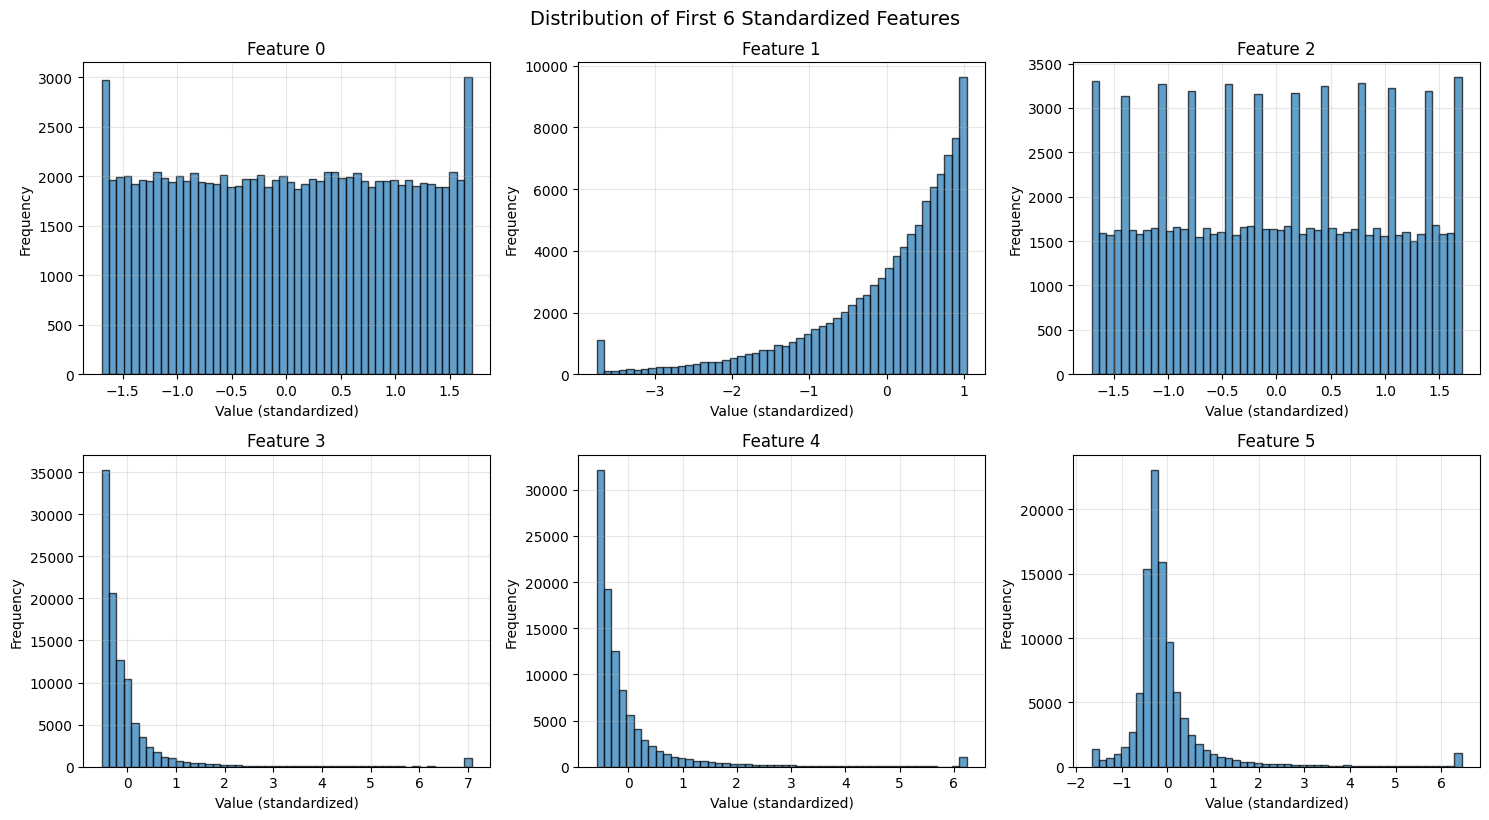

In [38]:
# Visualize distribution of first 5 features after preprocessing
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i in range(min(6, X_train.shape[1])):
    axes[i].hist(X_train[:, i], bins=50, alpha=0.7, edgecolor='black')
    axes[i].set_title(f'Feature {i}')
    axes[i].set_xlabel('Value (standardized)')
    axes[i].set_ylabel('Frequency')
    axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.suptitle('Distribution of First 6 Standardized Features', y=1.02, fontsize=14)
plt.show()

## 13. Data Ready for Modeling

The preprocessed data is now ready to be used with machine learning models. You have:

- **X_train**: Preprocessed training features (standardized)
- **y_train**: Training labels
- **X_test**: Preprocessed test features (standardized)
- **test_ids**: Test sample IDs for submission

All preprocessing steps performed:
1. ✅ Missing value imputation
2. ✅ Feature engineering (ratios, logs, interactions)
3. ✅ One-hot encoding
4. ✅ Outlier clipping
5. ✅ Standardization (z-score normalization)

You can now proceed to train your machine learning models!

In [39]:
# Single Jupyter cell: Sequential fraud detection pipeline using Stratified K-Fold validation
# Assumes the following preprocessed variables are already present in the notebook:
#   - X_train : preprocessed training features (standardized)\#   - y_train : training labels
#   - X_test  : preprocessed test features (standardized)
#   - test_ids: test sample IDs for submission
# Uses scikit-learn metrics for F1 and ROC AUC

import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score as sk_accuracy,
    precision_score as sk_precision,
    recall_score as sk_recall,
    f1_score as sk_f1,
    roc_auc_score as sk_roc_auc,
    confusion_matrix as sk_confusion_matrix
)
from sklearn.model_selection import StratifiedKFold

# Import project model implementation
from logistic_regression import LogisticRegression

print("=" * 60)
print("Sequential Fraud Detection Pipeline (single cell) — Stratified K-Fold validation")
print("=" * 60)

# -------------------------------------------------------------------------
# Sanity checks for required variables
# -------------------------------------------------------------------------
required_vars = ['X_train', 'y_train', 'X_test', 'test_ids']
missing = [v for v in required_vars if v not in globals()]
if missing:
    raise RuntimeError(f"Missing required preprocessed variables in the notebook namespace: {missing}")

# Ensure numpy arrays
X = np.asarray(X_train)
y = np.asarray(y_train)
X_test = np.asarray(X_test)

print(f"Preprocessed shapes: X={X.shape}, y={y.shape}, X_test={X_test.shape}")

# -------------------------------------------------------------------------
# Model configuration
# -------------------------------------------------------------------------
model_params = {
    'learning_rate': 0.0015,
    'n_iterations': 3000,
    'optimizer': "adam",
    'batch_size': 256,
    'regularization': 0.0006,
    'l1_ratio': 0.5,
    'class_weight': "balanced",
    'lr_schedule': "constant",
    'beta1': 0.9,
    'beta2': 0.999,
    'epsilon': 1e-8,
    'momentum': 0.0,
    'nesterov': False,
    'use_focal_loss': False,
    'focal_gamma': 2.0,
    'early_stopping': True,
    'patience': 350,
    'tol': 1e-9,
    'verbose': False
}
print("\nModel configuration:")
for k, v in model_params.items():
    print(f"  {k}: {v}")

# -------------------------------------------------------------------------
# Stratified K-Fold Cross-Validation
# -------------------------------------------------------------------------
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'auc': []}
thresholds_to_try = np.arange(0.05, 0.95, 0.02)

fold_idx = 0
# We'll also collect validation probabilities for optional analysis
for train_idx, val_idx in skf.split(X, y):
    fold_idx += 1
    print(f"\n--- Fold {fold_idx}/{n_splits} ---")
    X_tr, X_val = X[train_idx], X[val_idx]
    y_tr, y_val = y[train_idx], y[val_idx]
    print(f" Train samples: {X_tr.shape[0]}, Val samples: {X_val.shape[0]}")

    # Train model on this fold
    model = LogisticRegression(**model_params)
    model.fit(X_tr, y_tr)

    # Get validation probabilities (positive-class)
    proba_val_raw = model.predict_proba(X_val)
    if proba_val_raw.ndim > 1 and proba_val_raw.shape[1] > 1:
        proba_val = proba_val_raw[:, 1]
    else:
        proba_val = proba_val_raw

    # Find best threshold based on F1 for this fold
    best_f1_fold = -1.0
    best_thr_fold = 0.5
    for thr in thresholds_to_try:
        y_val_pred_thr = (proba_val >= thr).astype(int)
        f1_thr = sk_f1(y_val, y_val_pred_thr, zero_division=0)
        if f1_thr > best_f1_fold:
            best_f1_fold = f1_thr
            best_thr_fold = thr

    # Evaluate at the best threshold for this fold
    y_val_pred = (proba_val >= best_thr_fold).astype(int)
    acc = sk_accuracy(y_val, y_val_pred)
    prec = sk_precision(y_val, y_val_pred, zero_division=0)
    rec = sk_recall(y_val, y_val_pred, zero_division=0)
    f1 = sk_f1(y_val, y_val_pred, zero_division=0)
    auc = sk_roc_auc(y_val, proba_val)

    metrics['accuracy'].append(acc)
    metrics['precision'].append(prec)
    metrics['recall'].append(rec)
    metrics['f1'].append(f1)
    metrics['auc'].append(auc)

    cm = sk_confusion_matrix(y_val, y_val_pred)
    print(f" Fold best threshold: {best_thr_fold:.2f} (F1={best_f1_fold:.4f})")
    print(f"  Acc={acc:.4f}, Prec={prec:.4f}, Rec={rec:.4f}, F1={f1:.4f}, AUC={auc:.4f}")
    print(f"  Confusion matrix:\n{cm}")

# Cross-validation summary
print("\n=== Cross-validation summary ===")
for k in metrics:
    vals = np.array(metrics[k])
    print(f" {k.upper():8s}: mean={vals.mean():.4f}, std={vals.std():.4f}")

# -------------------------------------------------------------------------
# Retrain on full training data
# -------------------------------------------------------------------------
print("\nRetraining on full training data...")
model_full = LogisticRegression(**model_params)
model_full.fit(X, y)

# -------------------------------------------------------------------------
# Generate probabilities for test set and create submission (probabilities for AUC)
# -------------------------------------------------------------------------
print("\nGenerating submission (probabilities for AUC)...")
proba_test_raw = model_full.predict_proba(X_test)
if proba_test_raw.ndim > 1 and proba_test_raw.shape[1] > 1:
    proba_test = proba_test_raw[:, 1]
else:
    proba_test = proba_test_raw

print(f"Probability distribution on test set: min={proba_test.min():.4f}, max={proba_test.max():.4f}, mean={proba_test.mean():.4f}")

submission = pd.DataFrame({'ID': test_ids, 'is_fraud': proba_test})
submission.to_csv('submission.csv', index=False)
print("Submission saved to submission.csv (probabilities)")

# -------------------------------------------------------------------------
# Save model
# -------------------------------------------------------------------------
print("\nSaving model to logistic_model.json...")
try:
    model_full.save_model('logistic_model.json')
    print("Model saved to logistic_model.json")
except Exception as e:
    print(f"Failed to save model: {e}")

# -------------------------------------------------------------------------
# End summary
# -------------------------------------------------------------------------
print("\nPIPELINE SUMMARY")
print("Features used:", X.shape[1])
print(f"CV Mean AUC: {np.mean(metrics['auc']):.4f} (+/- {np.std(metrics['auc']):.4f})")
print(f"CV Mean F1 : {np.mean(metrics['f1']):.4f} (+/- {np.std(metrics['f1']):.4f})")
print("Predictions saved to: submission.csv (probabilities)")
print("=" * 60)


Sequential Fraud Detection Pipeline (single cell) — Stratified K-Fold validation
Preprocessed shapes: X=(100000, 83), y=(100000,), X_test=(100000, 83)

Model configuration:
  learning_rate: 0.0015
  n_iterations: 3000
  optimizer: adam
  batch_size: 256
  regularization: 0.0006
  l1_ratio: 0.5
  class_weight: balanced
  lr_schedule: constant
  beta1: 0.9
  beta2: 0.999
  epsilon: 1e-08
  momentum: 0.0
  nesterov: False
  use_focal_loss: False
  focal_gamma: 2.0
  early_stopping: True
  patience: 350
  tol: 1e-09
  verbose: False

--- Fold 1/5 ---
 Train samples: 80000, Val samples: 20000
Class weights: [0.58225858 3.5391966 ]
 Fold best threshold: 0.47 (F1=0.2747)
  Acc=0.5176, Prec=0.1744, Rec=0.6465, F1=0.2747, AUC=0.6032
  Confusion matrix:
[[8525 8649]
 [ 999 1827]]

--- Fold 2/5 ---
 Train samples: 80000, Val samples: 20000
Class weights: [0.58225858 3.5391966 ]
 Fold best threshold: 0.47 (F1=0.2796)
  Acc=0.5165, Prec=0.1771, Rec=0.6642, F1=0.2796, AUC=0.6065
  Confusion matrix:
